# Sequence Modeling

### Importing Libraries

In [223]:
# !pip install quantstats

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, 
    ELU, LSTM, Dense, 
    Dropout, TimeDistributed, 
    Conv1D, Conv2D, 
    MaxPooling1D, MaxPooling2D,
    Flatten, Bidirectional, 
    Input, Flatten, Activation, 
    Reshape, RepeatVector, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.saving import load_model

from utils import *

import quantstats as qs

import warnings
warnings.filterwarnings("ignore")

In [225]:
tf.random.set_seed(2024)
np.random.seed(2024)

### Data Loading & Preparation

In [226]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')

stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

index_returns = pd.read_pickle('data/index_returns.pkl')

In [227]:
# create test set of returns for the benchmark (SX5E index)

test_index_ret = index_returns.loc['2017-01-02':]

In [228]:
LOOK_BACK = 15
n_features = len(tukey.columns)
FORECAST_RANGE = 1

We want to start wit hthe first obsrvation of the actual test set (the whole 2018 year). However our model expect as input the previous 15 observations to perform a prediction. We need to "add" the last 15 observatin of the training set to the testing set.  

In [229]:
starting_date_test = tukey.loc[:'2017-01-02'].index[-(LOOK_BACK+1)]
starting_date_test

Timestamp('2016-12-08 00:00:00')

In [230]:
train_price, test_price = tukey.loc[:'2017-01-02'], tukey.loc[starting_date_test:]

In [231]:
train_price.shape, test_price.shape

((1016, 41), (269, 41))

In [232]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

In [233]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print('(Samples, time steps, features)')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(Samples, time steps, features)
(1001, 15, 41)
(1001, 1, 41)
(254, 15, 41)
(254, 1, 41)


In [234]:
pd.DataFrame(scaled_train).head(16)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0.541517,0.461622,0.034626,0.257120,0.013959,0.100755,0.169548,0.251664,0.429280,0.069447,...,0.016829,0.490880,0.029139,0.324387,0.173636,0.852899,0.899366,0.831756,0.049210,0.067080
1,0.529201,0.461799,0.034262,0.278435,0.003311,0.105064,0.177072,0.242479,0.415421,0.069170,...,0.007411,0.499854,0.019105,0.311892,0.180203,0.844386,0.895234,0.851984,0.042860,0.071488
2,0.516797,0.457860,0.036727,0.296042,0.000000,0.111241,0.184239,0.232479,0.412488,0.061482,...,0.006851,0.517925,0.012021,0.303981,0.189000,0.850401,0.895617,0.872443,0.035237,0.076776
3,0.507911,0.447295,0.034189,0.308523,0.004506,0.120639,0.181054,0.216559,0.409791,0.051458,...,0.000000,0.539547,0.008036,0.297443,0.197833,0.857331,0.891148,0.892111,0.023188,0.088735
4,0.508034,0.438925,0.037815,0.311910,0.032780,0.131367,0.187847,0.208864,0.419323,0.052887,...,0.000213,0.566854,0.008782,0.300046,0.204064,0.877588,0.891316,0.905895,0.018373,0.097186
5,0.511512,0.422013,0.041265,0.309480,0.062710,0.139578,0.178564,0.201452,0.420097,0.056054,...,0.002047,0.569700,0.009469,0.304128,0.211047,0.882571,0.890789,0.912355,0.015429,0.100457
6,0.521391,0.414747,0.040609,0.312093,0.061864,0.144239,0.165171,0.203834,0.430032,0.054294,...,0.004082,0.569046,0.004827,0.296455,0.212109,0.888026,0.879558,0.912538,0.022499,0.095597
7,0.522908,0.406736,0.044093,0.281079,0.061828,0.142693,0.157912,0.216265,0.429174,0.051623,...,0.013135,0.573871,0.000000,0.272436,0.210314,0.894143,0.863180,0.907484,0.033346,0.091237
8,0.526643,0.404740,0.043780,0.278568,0.063943,0.142578,0.153651,0.230493,0.420234,0.050776,...,0.027586,0.576559,0.002892,0.238750,0.206102,0.893838,0.852046,0.902328,0.037035,0.091054
9,0.530767,0.401711,0.042236,0.284384,0.087248,0.146637,0.145950,0.244864,0.413457,0.048868,...,0.039572,0.581729,0.024220,0.222509,0.197721,0.892704,0.842585,0.900060,0.044900,0.087584


In [235]:
X_train.shape

(1001, 15, 41)

Everything matches. Each row of my dataset is an element of the arrays: 1001 samples where each sample has 15 timesteps for each of the 41 stocks. The sequences are ready for training.

### Useful Functions

In [236]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

# aggregated metrics
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae.numpy())
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse.numpy())
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape.numpy())


# metrics for each stock
def calculate_metrics(y_test_inverse, yhat_inverse, tukey):
    metrics_df = pd.DataFrame(columns=['Stock', 'MAE', 'MSE', 'MAPE'])
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()

    for stock in range(y_test_inverse.shape[1]):
        stock_name = tukey.iloc[:, stock].name
        mae = mae_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mse = mse_(y_test_inverse[:, stock], yhat_inverse[:, stock])
        mape = mape_(y_test_inverse[:, stock], yhat_inverse[:, stock])

        metrics_df.loc[len(metrics_df)] = [stock_name, mae.numpy(), mse.numpy(), mape.numpy()]
        # metrics_df = metrics_df.append({'Stock': stock_name, 'MAE': mae.numpy(), 'MSE': mse.numpy(), 'MAPE': mape.numpy()}, ignore_index=True)
    
    return metrics_df


def plot_preds(yhat, ytest, metrics_df, model_name):
    # convert to df for nice plotting
    if isinstance(yhat, np.ndarray):
        predictions = pd.DataFrame(yhat, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
    if isinstance(ytest, np.ndarray):
        y_test_inverse_df = pd.DataFrame(ytest, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

    rand = np.random.choice(np.arange(41), size=10, replace=False)      # 10 stock random sample without replacement
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))

    for i, stock in enumerate(rand):
        row = i // 5
        col = i % 5
        axs[row, col].plot(predictions.iloc[:, stock], color='blue',
                           label='Predicted')
        axs[row, col].plot(y_test_inverse_df.iloc[:, stock], color='red', label='Realized')
        axs[row, col].set_title(predictions.iloc[:, stock].name)
        axs[row, col].tick_params(axis='x', rotation=45)
        
        # metrics in top left
        axs[row, col].annotate(f"MAE: {metrics_df.loc[stock, 'MAE']:.2f}\nMSE: {metrics_df.loc[stock, 'MSE']:.2f}\nMAPE: {metrics_df.loc[stock, 'MAPE']:.2f}", 
                               xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

    plt.suptitle(f"{model_name}: predicted vs realized", fontsize=16)
    
    # bottom legend
    handles, labels = axs[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.tight_layout()
    plt.show()
    
    
def plot_top_N(predictions, y_test_inverse_df, number_of_stocks, model_name, metrics_df):
    
    portfolios = get_ranking(predictions, N = [5, 7, 10], prices=True)
    portfolios = portfolios[f'Top {number_of_stocks}']

    # Calculate the number of rows and columns dynamically based on the number of stocks
    num_stocks = len(portfolios)
    num_rows = math.ceil(num_stocks / 5)
    num_cols = min(num_stocks, 5)

    # Create subplots dynamically
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 3 * num_rows))
    fig.suptitle(f"{model_name}: predicted vs realized", fontsize=16)

    for i, stock in enumerate(portfolios):
        row = i // 5
        col = i % 5
        axs[row, col].plot(predictions.loc[:, stock], color='blue', label='Predicted')
        axs[row, col].plot(y_test_inverse_df.loc[:, stock], color='red', label='Realized')
        axs[row, col].set_title(predictions.loc[:, stock].name)
        axs[row, col].tick_params(axis='x', rotation=45)

        # metrics in top left
        axs[row, col].annotate(f"MAE: {metrics_df.loc[i, 'MAE']:.2f}\nMSE: {metrics_df.loc[i, 'MSE']:.2f}\nMAPE: {metrics_df.loc[i, 'MAPE']:.2f}",
                            xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=10,
                            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5))

    # bottom legend
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Sequence-2-Sequence Modeling (many-to-many) with LSTMs:

Using encoder-decoder architectures to forecast multiple time series with one model. The encoder is basically responsible for reading and interpreting the input. The encoder part compresses the input into a small representation (a fixed-length vector) of the original input, and this "context vector" is given to the decoder part as input to be interpreted and perform forecasting.
- **RepeatVector** layer is used to repeat N times the context vector we obtain from the encoder part. N is the number of future steps you want to forecast and is fed into the decoder part.
- A fully connected Dense layer is applied to each time step via **TimeDistributed** wrapper, so separates the output for each time step. The TimeDistributed allows to treat independently each time series.

### LSTM

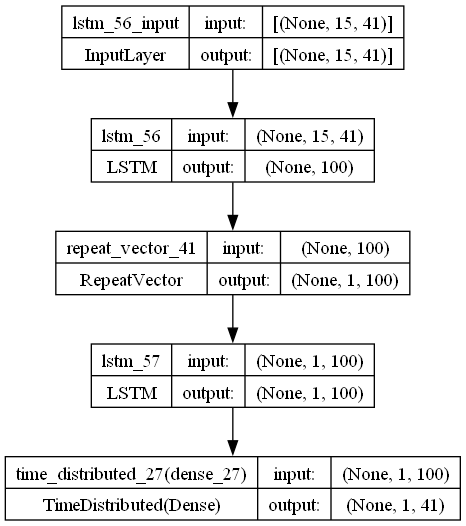

In [237]:
lstm = Sequential(name='LSTM')
lstm.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
lstm.add(RepeatVector(FORECAST_RANGE))
lstm.add(LSTM(100, activation='relu', return_sequences=True))
lstm.add(TimeDistributed(Dense(n_features)))

lstm.compile(optimizer='adam', loss='mse')

plot_model(model=lstm, show_shapes=True, to_file='model images/LSTM.png')

In [238]:
history = lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


32/32 [==============================] - 3s 11ms/step - loss: 0.1637
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0270
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0152
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0114
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0083
Epoch 6/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 7/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0052
Epoch 8/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0046
Epoch 9/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0039
Epoch 10/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0034
Epoch 11/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0031
Epoch 12/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0029
Epoch 13/50
32/32 [==============================] - 

In [239]:
lstm.save('Models/LSTM.keras')
# lstm = load_model('Models/LSTM.keras')

In [240]:
yhat = lstm.predict(X_test, verbose=0)

In [241]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [242]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.764338
mse: 62.348362
mape: 7.8247766


In [243]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

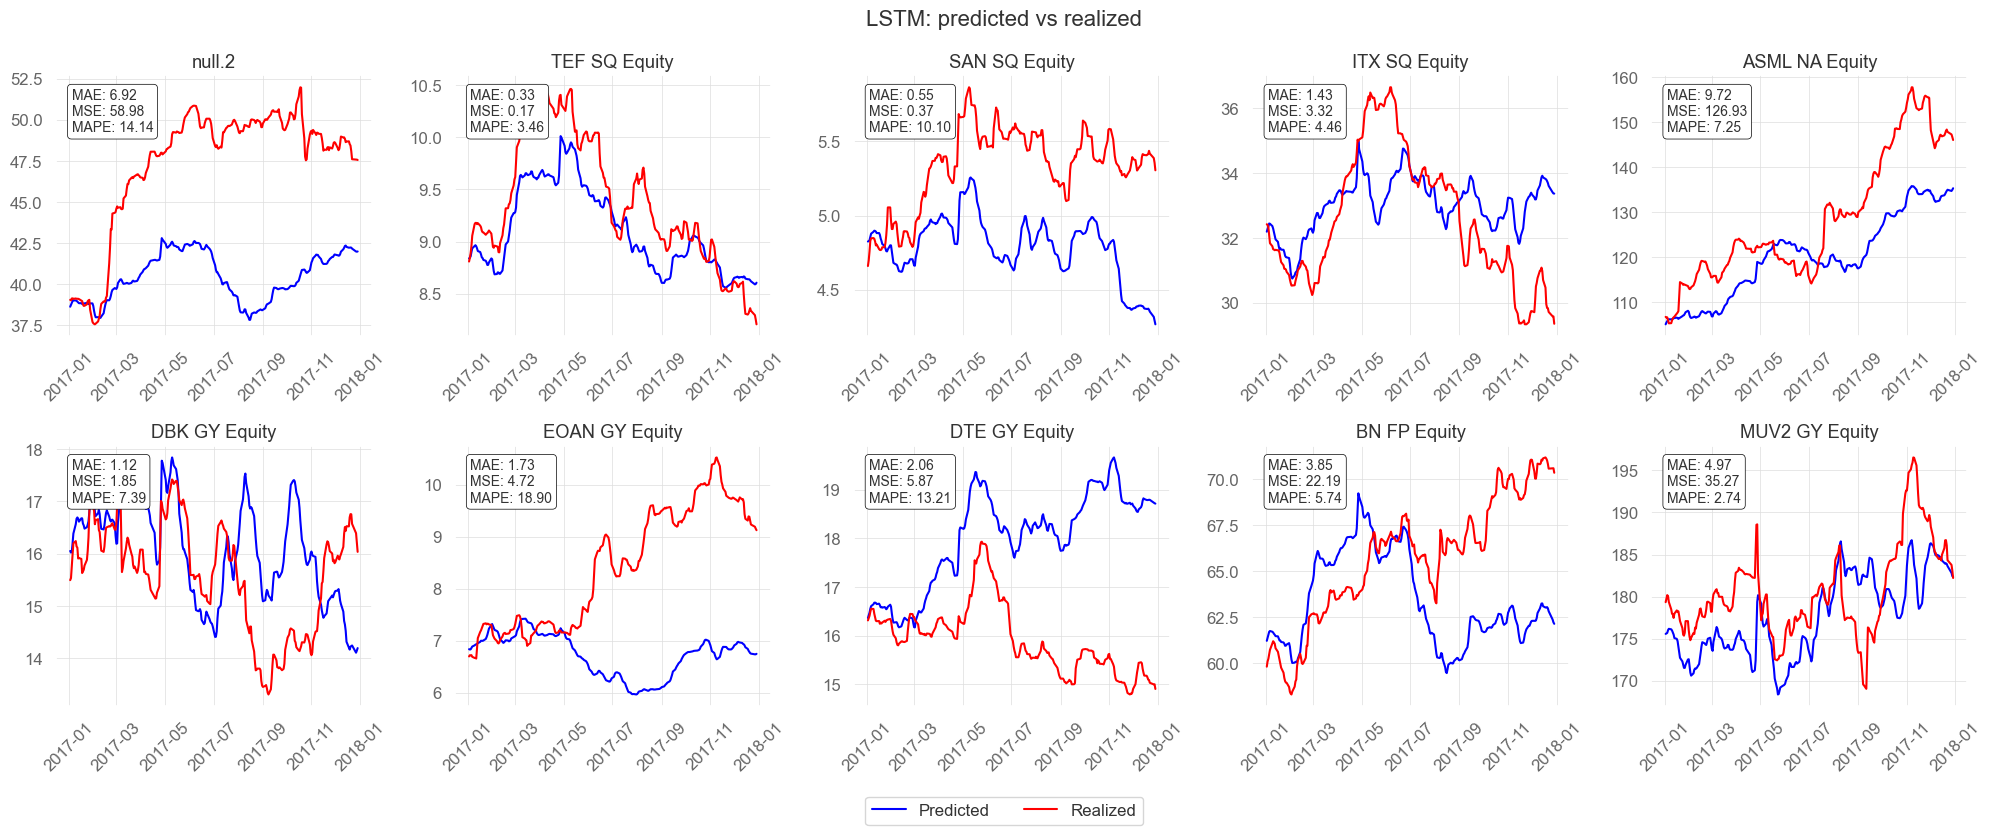

In [244]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=lstm.name)

### Portfolio creation, optimization and comparison:
- Ranking the predictions
- Selecting stocks
- Calculate performance of portfolios for different N selections
- Plot the portfolios
- Compare with index

In [245]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [247]:
ranking_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
perf_LSTM, portfolios_ret_LSTM = calc_portfolios(ranking_LSTM, stocks_returns.loc[yhat_inverse_df.index[0]:])

perf_LSTM['Index total performance'] = ((1 + test_index_ret).prod() - 1) * 100
perf_LSTM

{'Top 5 total performance': 20.589655522598328,
 'Top 7 total performance': 15.15722319117927,
 'Top 10 total performance': 10.819798731961484,
 'Index total performance': 8.73696808872011}

In [75]:
plot_top_N(yhat_inverse_df, y_test_inverse_df, 5, lstm.name, metrics_df)

TypeError: plot_top_N() missing 1 required positional argument: 'yhat_inverse_df'

In [76]:
plot_portfolios(portfolios_ret_LSTM, test_index_ret)

In [77]:
report = qs.reports.metrics(portfolios_ret_LSTM['Top 7 returns'],
                benchmark = test_index_ret,
                title = 'LSTM: Top5 vs Benchmark',
                mode = "basic",
                prepare_returns = False)

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2017-01-02   2017-01-02
End Period          2017-12-29   2017-12-29
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   8.74%        18.44%
CAGR﹪              6.02%        12.54%

Sharpe              0.89         1.55
Prob. Sharpe Ratio  81.81%       94.6%
Sortino             1.41         2.58
Sortino/√2          1.0          1.82
Omega               1.31         1.31

Max Drawdown        -6.79%       -6.23%
Longest DD Days     171          129

Gain/Pain Ratio     0.16         0.31
Gain/Pain (1M)      0.88         3.06

Payoff Ratio        1.09         1.24
Profit Factor       1.16         1.31
Common Sense Ratio  1.42         1.63
CPC Index           0.65         0.83
Tail Ratio          1.23         1.25
Outlier Win Ratio   3.54         2.98
Outlier Loss Ratio  3.21         3.09

MTD                 -1.8%        -1.82%
3M           

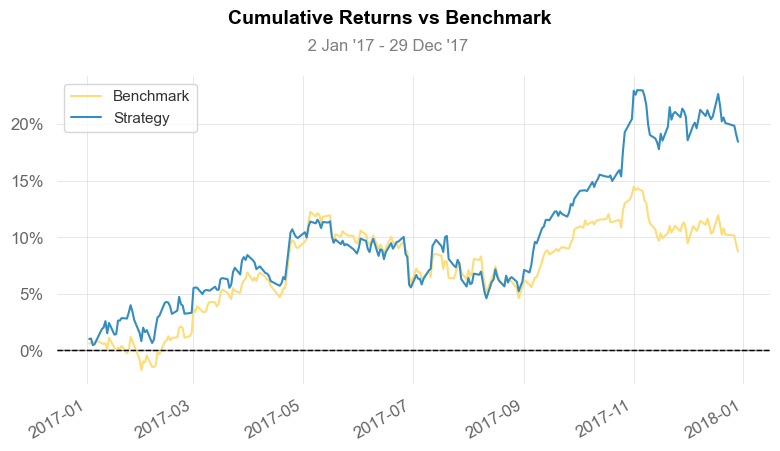

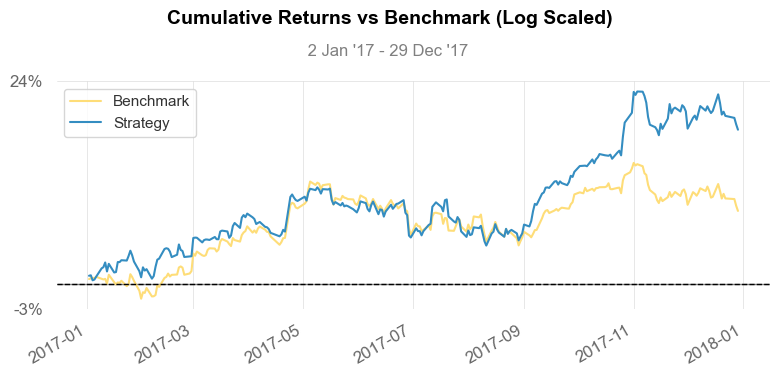

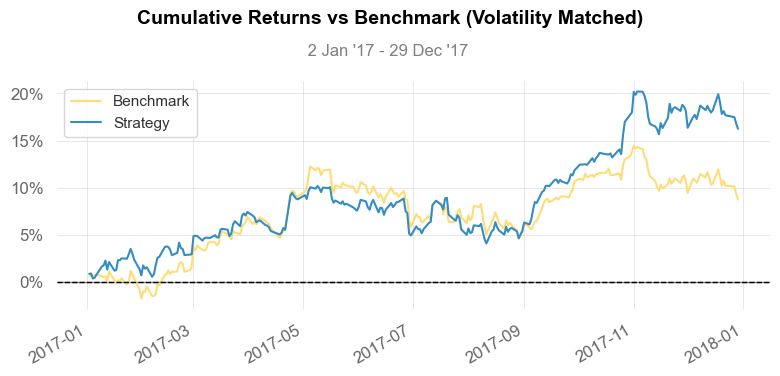

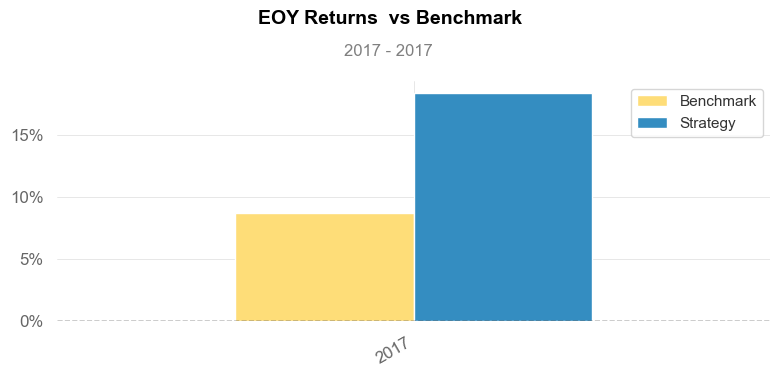

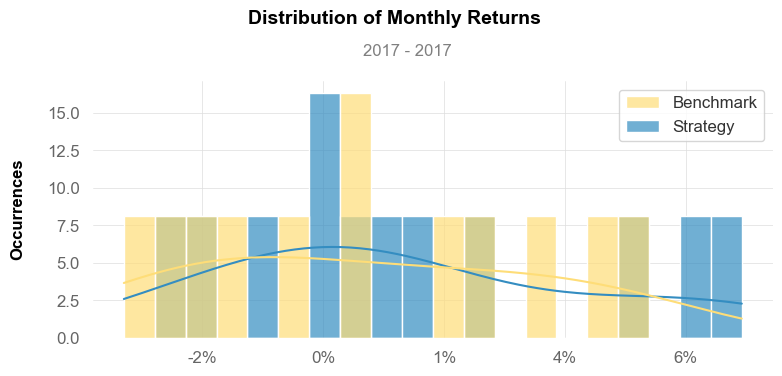

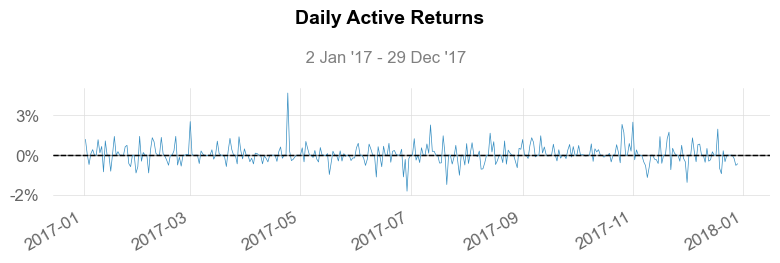

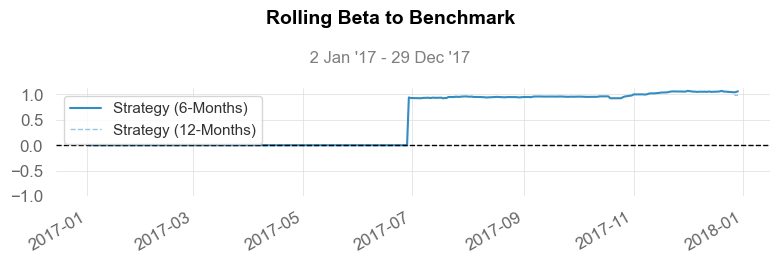

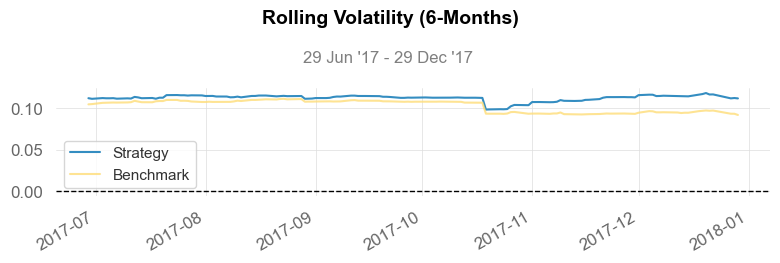

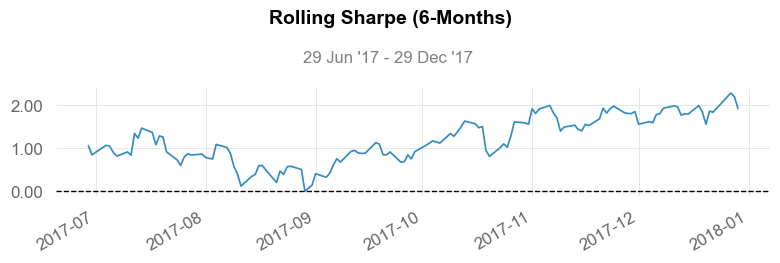

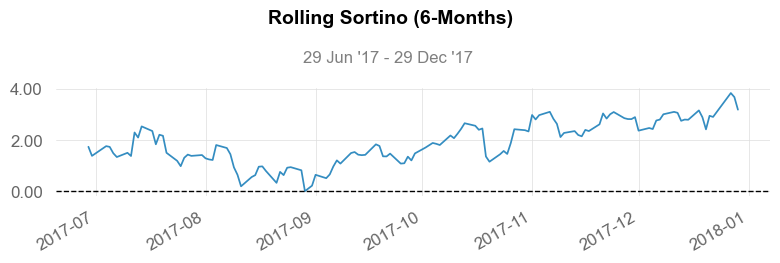

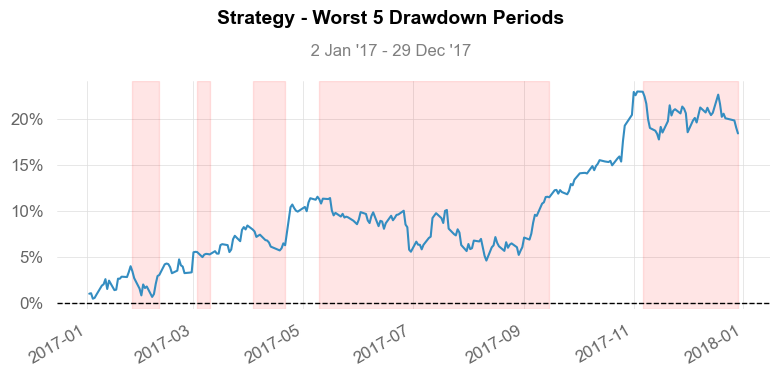

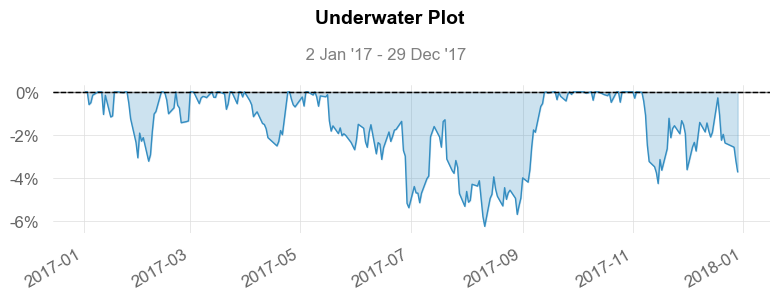

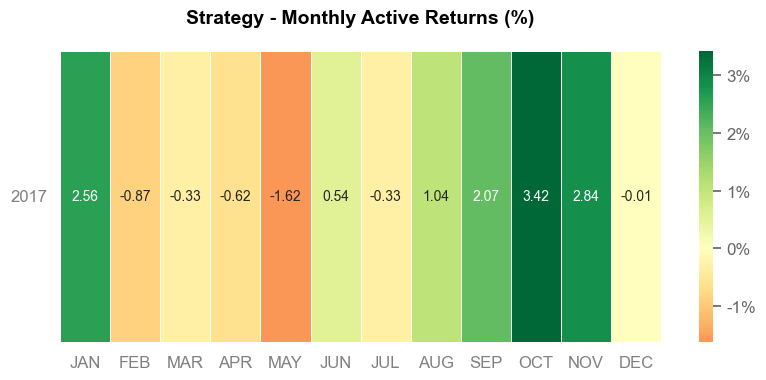

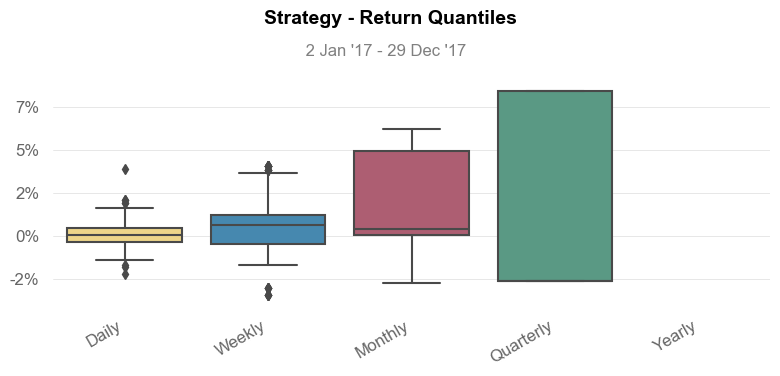

In [78]:
qs.reports.plots(portfolios_ret_LSTM['Top 7 returns'],
                benchmark = test_index_ret,
                title = 'LSTM: Top5 vs Benchmark',
                mode = "full",
                prepare_returns = False)

### CNN encoder - LSTM decoder

In [150]:
cnn_lstm = Sequential(name='CNN-LSTM')
cnn_lstm.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
cnn_lstm.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
cnn_lstm.add(MaxPooling1D(pool_size=2))
cnn_lstm.add(Flatten())
cnn_lstm.add(RepeatVector(FORECAST_RANGE))
cnn_lstm.add(LSTM(200, activation='relu', return_sequences=True))
cnn_lstm.add(TimeDistributed(Dense(100, activation='relu')))
cnn_lstm.add(TimeDistributed(Dense(n_features)))

cnn_lstm.compile(loss='mse', optimizer='adam')

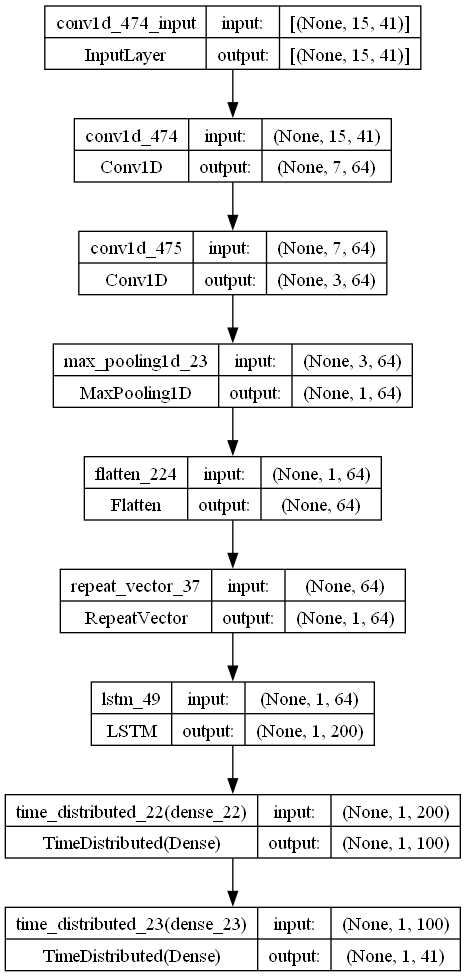

In [151]:
plot_model(model=cnn_lstm, show_shapes=True, to_file='model images/CNN-LSTM.png')

In [152]:
history = cnn_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


32/32 [==============================] - 3s 6ms/step - loss: 0.1065
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0184
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0130
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0114
Epoch 5/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0078
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0065
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0059
Epoch 9/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0053
Epoch 10/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 11/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 12/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 13/50
32/32 [==============================] - 0s 6ms/

In [153]:
cnn_lstm.save('Models/CNN_LSTM.keras')
# cnn_lstm = load_model('Models/CNN_LSTM.keras')

In [154]:
yhat = cnn_lstm.predict(X_test, verbose=0)

In [155]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [156]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.212356
mse: 60.76835
mape: 6.7595572


In [157]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

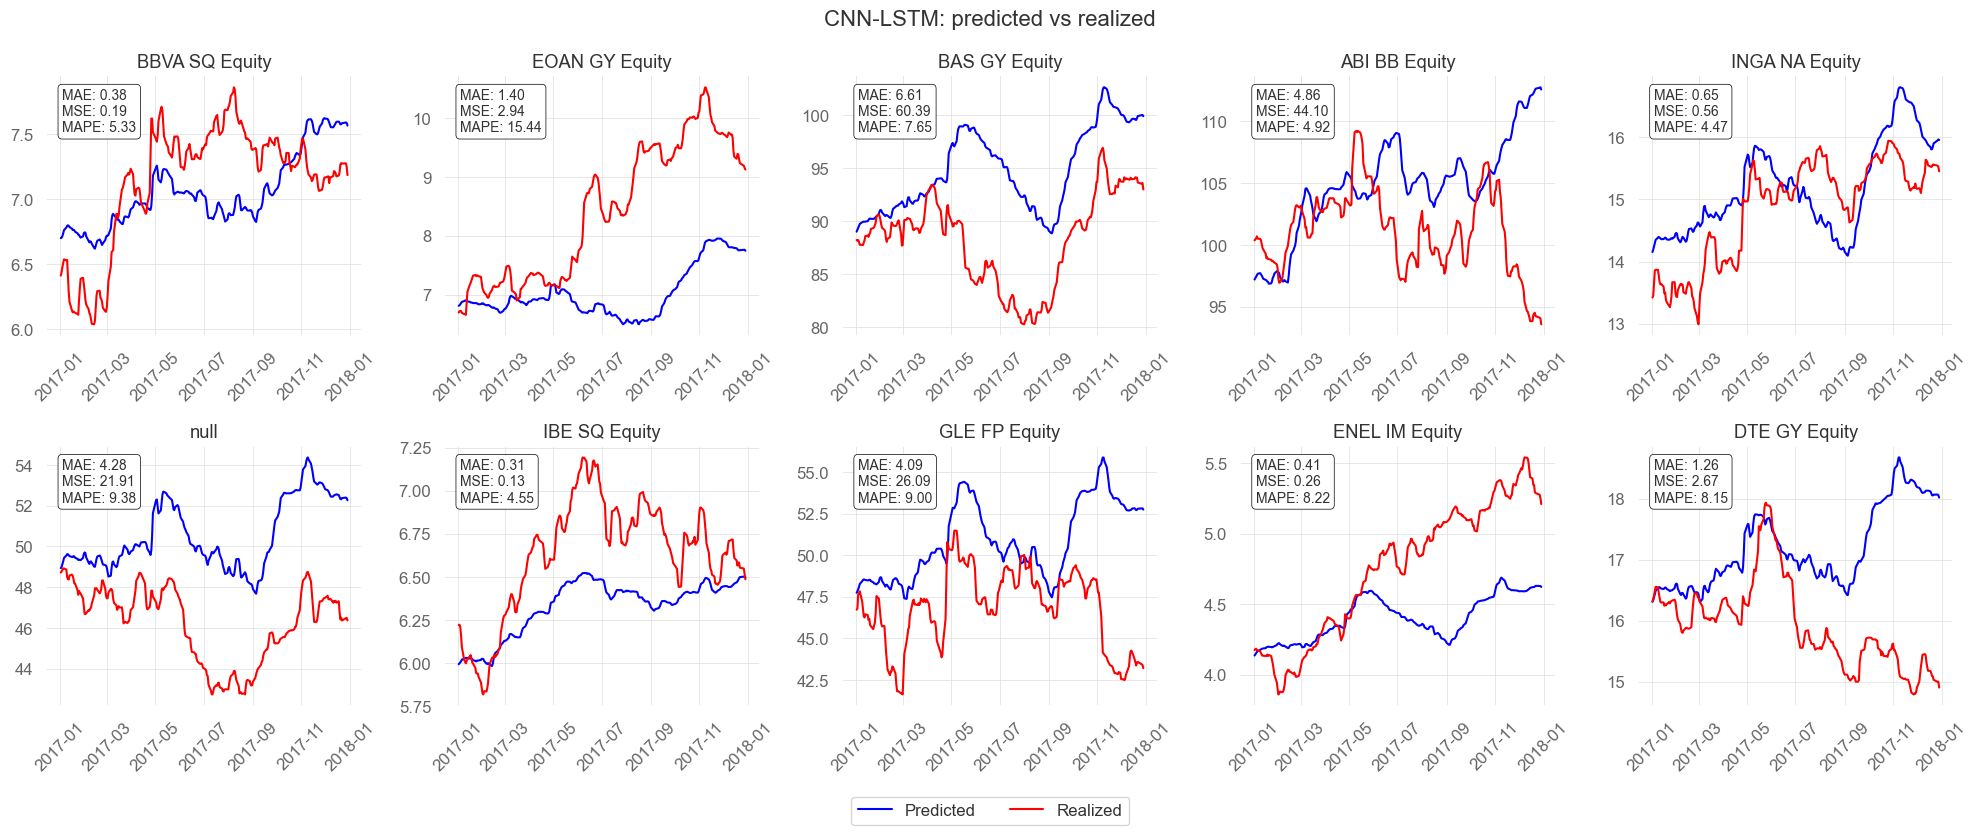

In [158]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=cnn_lstm.name)

### Portfolio creation, optimization and comparison:

In [159]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [160]:
ranking_CNN_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
perf_CNN_LSTM, portfolios_ret_CNN_LSTM = calc_portfolios(ranking_CNN_LSTM, stocks_returns.loc[yhat_inverse_df.index[0]:])

perf_CNN_LSTM['Index total performance'] = ((1 + test_index_ret).prod() - 1) * 100
perf_CNN_LSTM

{'Top 5 total performance': 13.810979061519003,
 'Top 7 total performance': 9.7289033300471,
 'Top 10 total performance': 8.885860175726412,
 'Index total performance': 0.0873696808872011}

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

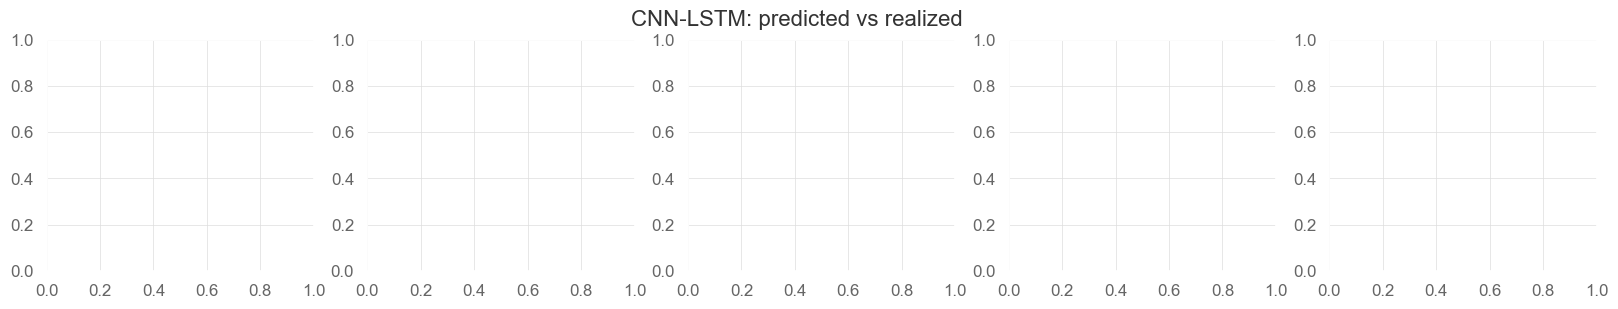

In [161]:
plot_top_N(yhat_inverse_df, y_test_inverse_df, 5, cnn_lstm.name, metrics_df)

In [ ]:
plot_portfolios(portfolios_ret_CNN_LSTM, test_index_ret)

In [ ]:
qs.reports.metrics(portfolios_ret_CNN_LSTM['Top5 returns'],
                benchmark = test_index_ret,
                title = 'CNN-LSTM: Top5 vs Benchmark',
                mode = "basic",
                prepare_returns = False)

In [ ]:
qs.reports.plots(portfolios_ret_CNN_LSTM['Top5 returns'],
                benchmark = test_index_ret,
                title = 'CNN-LSTM: Top5 vs Benchmark',
                mode = "full",
                prepare_returns = False)

### Multi-Head CNN-LSTM

The multi-head structure uses multiple one-dimensional CNN layers in order to process each time series and extract independent convolved features from each time series. These separate CNNs are called “head” and flattened, concatenated, and reshaped respectively before feeding into the LSTM layer. Therefore, they might be more successful to keep significant features of each time series and make better forecasts in this sense.

https://www.sciencedirect.com/science/article/pii/S0925231219309877

In [162]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
# 41 "heads", each to extract feats from each ts
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=5, kernel_size=4, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=7, kernel_size=8, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation='relu')(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation='relu', return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = TimeDistributed(Dense(n_features))(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense, name='Multi-Head-CNN-LSTM')

multi_head_cnn_lstm_model.compile(loss='mse', optimizer='adam')

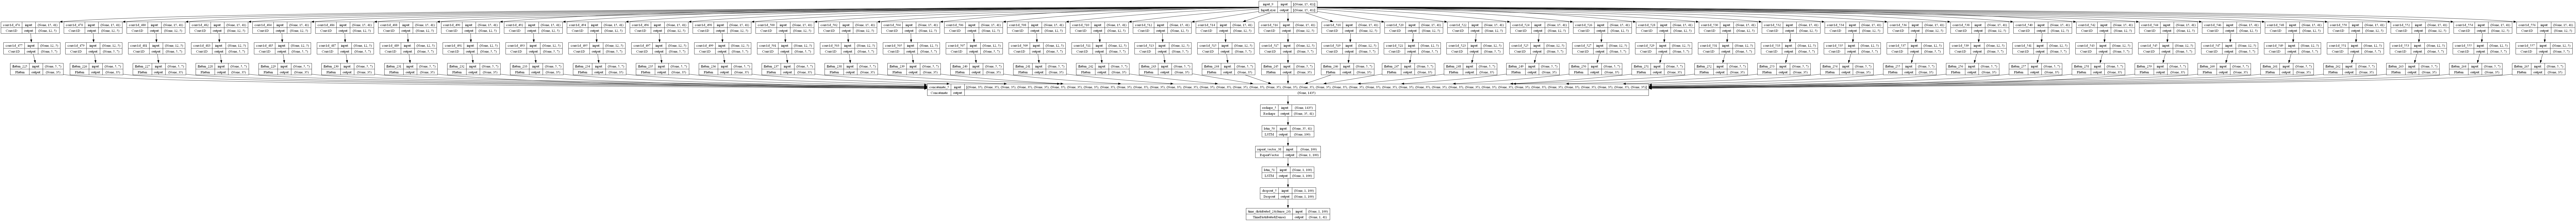

In [163]:
plot_model(model=multi_head_cnn_lstm_model, show_shapes=True, to_file="model images/multi head cnn lstm.png")

In [164]:
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=70, batch_size=32)

Epoch 1/70


32/32 [==============================] - 26s 35ms/step - loss: 0.1848
Epoch 2/70
32/32 [==============================] - 1s 34ms/step - loss: 0.0592
Epoch 3/70
32/32 [==============================] - 1s 34ms/step - loss: 0.0492
Epoch 4/70
32/32 [==============================] - 1s 34ms/step - loss: 0.0372
Epoch 5/70
32/32 [==============================] - 1s 36ms/step - loss: 0.0286
Epoch 6/70
32/32 [==============================] - 1s 34ms/step - loss: 0.0254
Epoch 7/70
32/32 [==============================] - 1s 33ms/step - loss: 0.0238
Epoch 8/70
32/32 [==============================] - 1s 33ms/step - loss: 0.0229
Epoch 9/70
32/32 [==============================] - 1s 34ms/step - loss: 0.0217
Epoch 10/70
32/32 [==============================] - 1s 33ms/step - loss: 0.0200
Epoch 11/70
32/32 [==============================] - 1s 33ms/step - loss: 0.0187
Epoch 12/70
32/32 [==============================] - 1s 34ms/step - loss: 0.0187
Epoch 13/70
32/32 [============================

In [ ]:
multi_head_cnn_lstm_model.save('Models/M_CNN_LSTM.keras')
# multi_head_cnn_lstm_model = load_model('Models/M_CNN_LSTM.keras')

In [165]:
yhat = multi_head_cnn_lstm_model.predict(X_test, verbose=0)

In [166]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [167]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.658262
mse: 71.73874
mape: 7.7074833


In [168]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

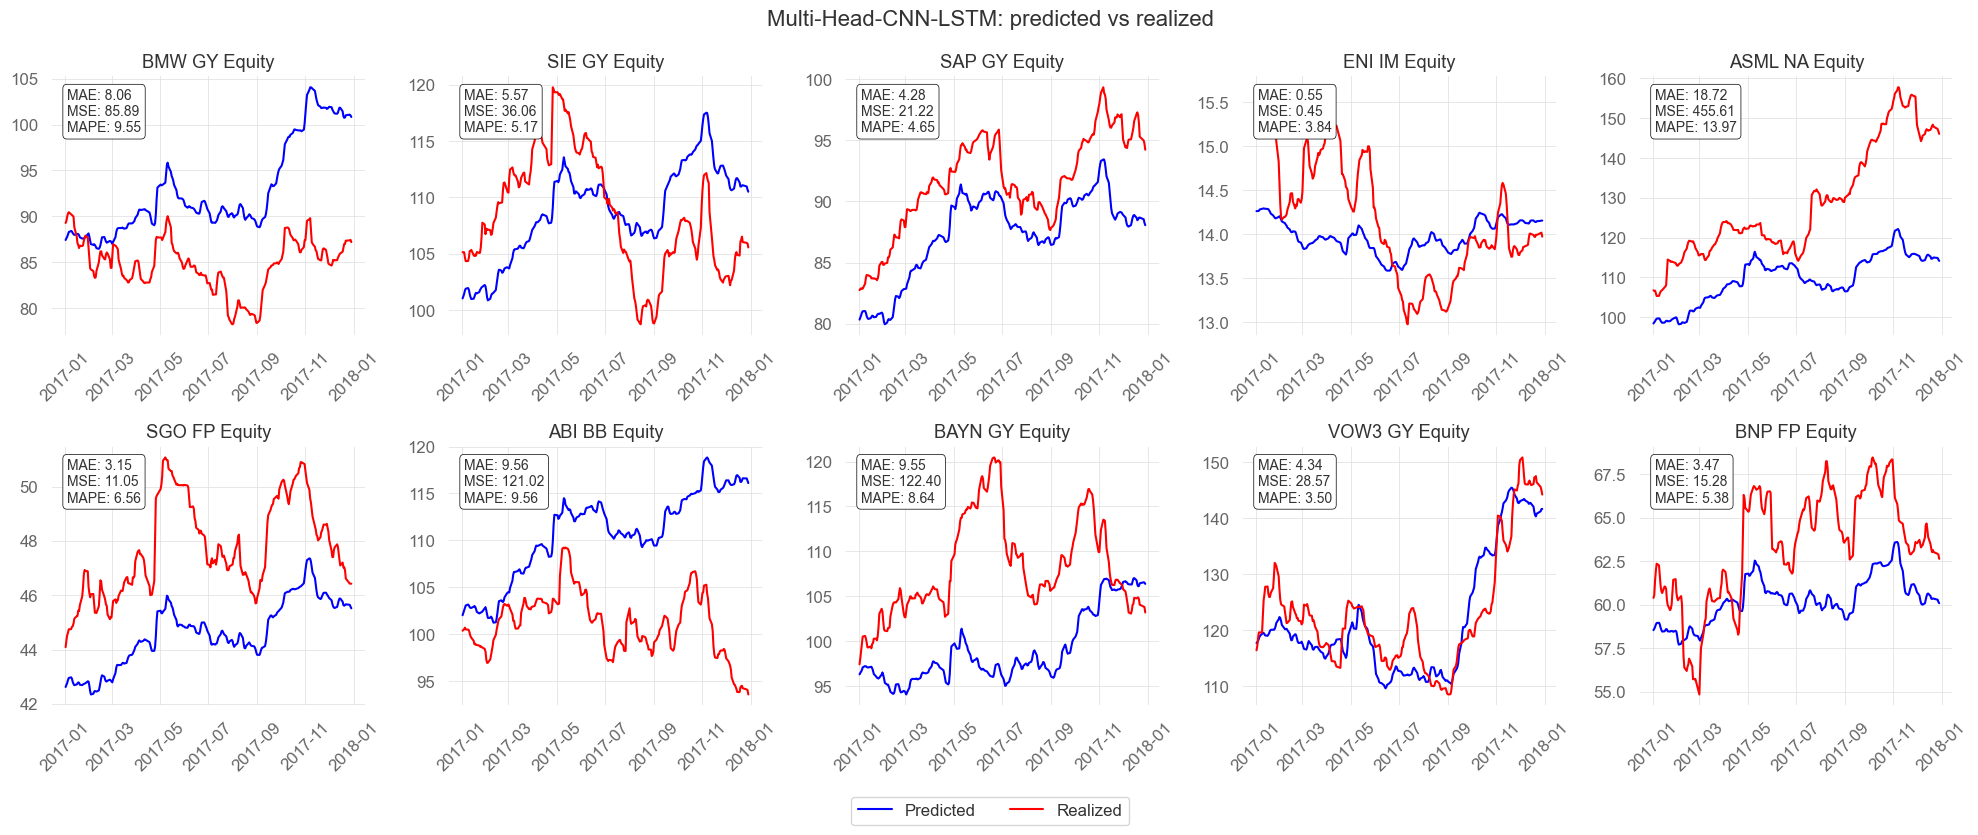

In [169]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=multi_head_cnn_lstm_model.name)

### Portfolio creation, optimization and comparison:

In [171]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [173]:
ranking_MH_LSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
perf_MH_LSTM, portfolios_ret_MH_LSTM = calc_portfolios(ranking_MH_LSTM, stocks_returns.loc[yhat_inverse_df.index[0]:])

perf_MH_LSTM['Index total performance'] = ((1 + test_index_ret).prod() - 1) * 100
perf_MH_LSTM

{'Top 5 total performance': 18.55378178003544,
 'Top 7 total performance': 13.123580425298442,
 'Top 10 total performance': 9.27668900804317,
 'Index total performance': 8.73696808872011}

In [ ]:
plot_top_N(yhat_inverse_df, y_test_inverse_df, 5, multi_head_cnn_lstm_model.name, metrics_df)

In [ ]:
plot_portfolios(portfolios_ret_MH_LSTM, test_index_ret)

In [ ]:
qs.reports.metrics(portfolios_ret_MH_LSTM['Top5 returns'],
                benchmark = test_index_ret,
                title = 'LSTM: Top5 vs Benchmark',
                mode = "basic",
                prepare_returns = False)

In [ ]:
qs.reports.plots(portfolios_ret_MH_LSTM['Top5 returns'],
                benchmark = test_index_ret,
                title = 'LSTM: Top5 vs Benchmark',
                mode = "full",
                prepare_returns = False)

### CNN-BiLSTM

In [ ]:
plot_model(model=cnn_bilstm, show_shapes=True)

NameError: name 'cnn_bilstm' is not defined

In [ ]:
history = cnn_bilstm.fit(X_train, y_train, epochs=50, batch_size=32)

In [ ]:
yhat = cnn_bilstm.predict(X_test, verbose=0)

In [ ]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [ ]:
evaluate_forecast(y_test_inverse, yhat_inverse)

In [ ]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

In [ ]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=cnn_bilstm.name)

### Portfolio creation, optimization and comparison:

In [ ]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [ ]:
ranking_CNN_BILSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
perf_CNN_BILSTM, portfolios_ret_CNN_BILSTM = calc_portfolios(ranking_CNN_BILSTM, stocks_returns.loc[yhat_inverse_df.index[0]:])

perf_CNN_BILSTM['Index total performance'] = (1 + test_index_ret).prod() - 1
perf_CNN_BILSTM

{'Top5 performance': 24.633624660235068,
 'Top7 performance': 15.88547779858768,
 'Top10 performance': 16.4568360621696,
 'Index performance': 7.519056769262942}

In [ ]:
plot_portfolios(portfolios_ret_CNN_BILSTM, test_index_ret)

In [ ]:
qs.reports.full(portfolios_ret_CNN_BILSTM['Top5 returns'],
                benchmark = test_index_ret,
                title = 'LSTM: Top5 vs Benchmark',
                mode = "basic",
                prepare_returns = False)

---
---
---

## Testing custom LSTMs

#### Stacking 2 LSTM Encoder + 2 LSTM Decoder

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(LOOK_BACK, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]

decoder_inputs = tf.keras.layers.RepeatVector(FORECAST_RANGE)(encoder_outputs2[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

model_e2d2.compile(loss='mse', optimizer='adam')

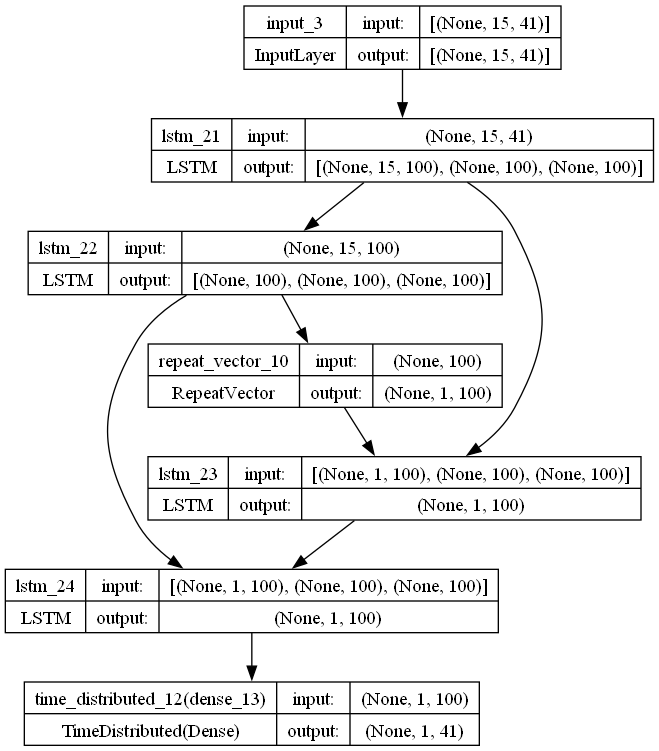

In [ ]:
plot_model(model=model_e2d2, show_shapes=True)

In [ ]:
history = model_e2d2.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 8s 18ms/step - loss: 0.0708
Epoch 2/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0122
Epoch 3/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0073
Epoch 4/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0053
Epoch 5/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0042
Epoch 6/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0033
Epoch 7/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0029
Epoch 8/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0026
Epoch 9/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0024
Epoch 10/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0023
Epoch 11/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0021
Epoch 12/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0019
Epoch 13/50
32/32 [==================

In [ ]:
yhat = model_e2d2.predict(X_test, verbose=0)

In [ ]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [ ]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 3.959789
mse: 61.27117
mape: 5.9940686


In [ ]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

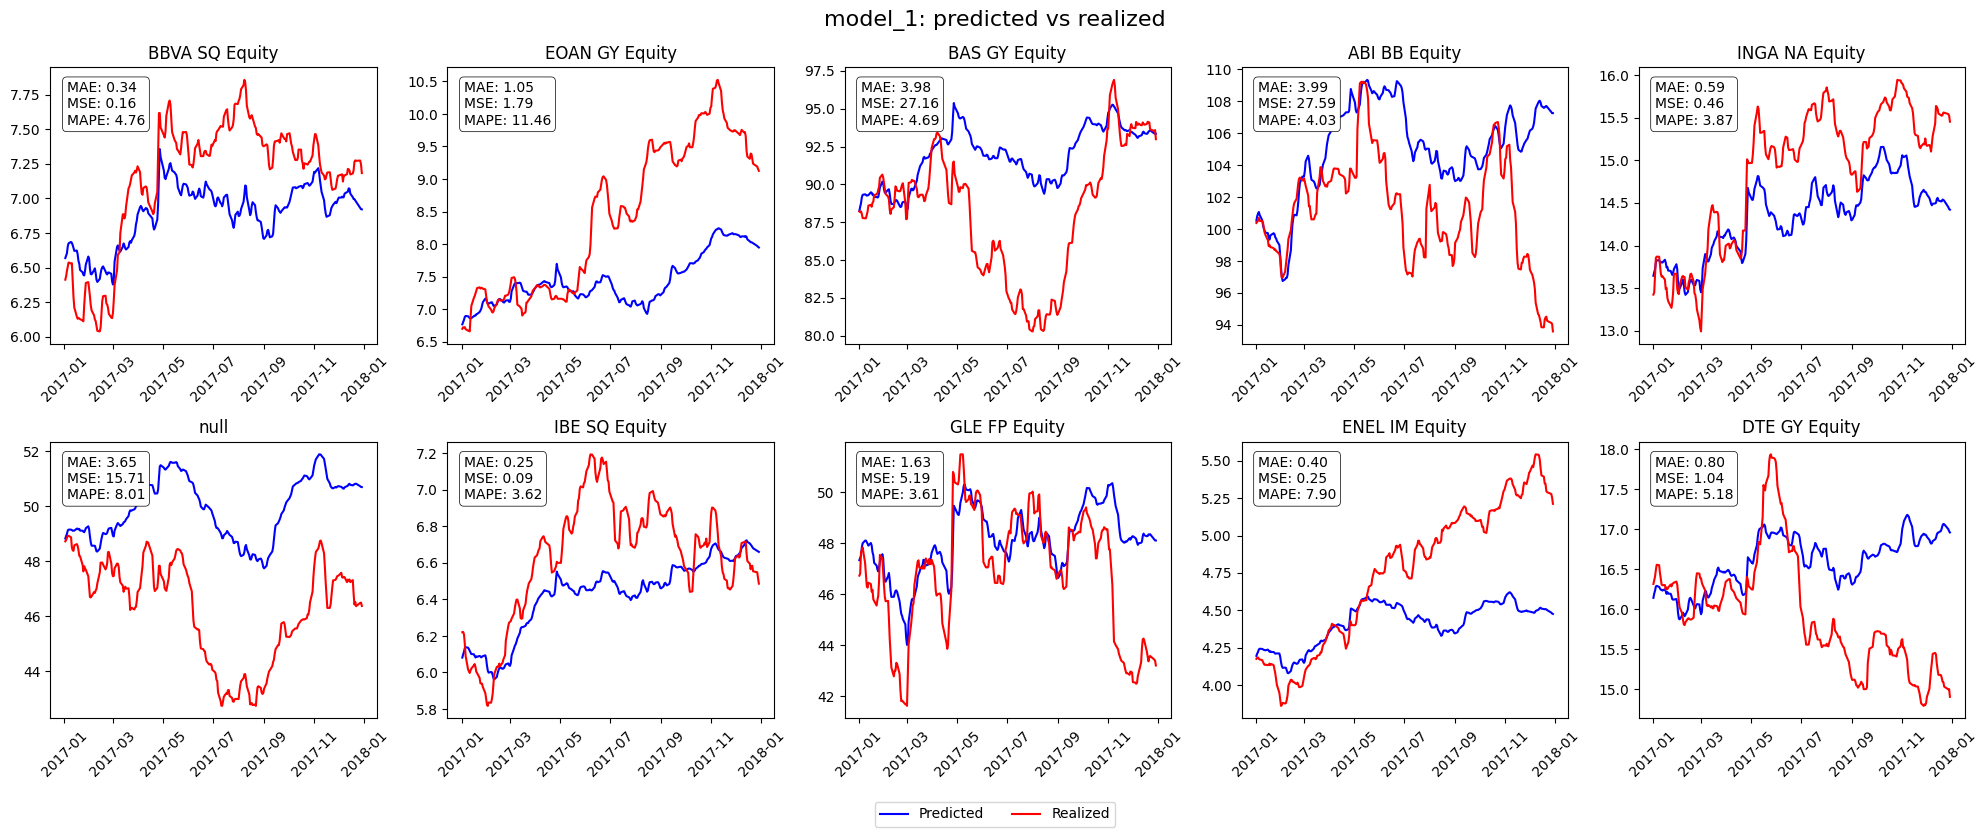

In [ ]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=model_e2d2.name)

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [ ]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [ ]:
initial_inv = 1000

test_index_series = index.loc['2017-01-02':]
test_index_series = ((test_index_series / test_index_series.iloc[0]) * initial_inv)
test_index_series = pd.Series(test_index_series['Close'], index = test_index_series.index)

portfolios_CNN_biLSTM = get_ranking(yhat_inverse_df, N = [5, 7, 10], prices=True)
 
tot_performance_CNN_biLSTM, portfolio_series_CNN_biLSTM = calc_portfolios(portfolios_CNN_biLSTM, tukey.loc[yhat_inverse_df.index[0]:], initial_investment=initial_inv)

tot_performance_CNN_biLSTM['Index performance'] = ((test_index_series[-1] - test_index_series[0]) / test_index_series[0]) * 100
tot_performance_CNN_biLSTM

{'Top5 performance': 20.692116365614925,
 'Top7 performance': 20.076127644721623,
 'Top10 performance': 17.87039622701559,
 'Index performance': 7.519056769262942}

In [ ]:
plot_portfolios(portfolio_series_CNN_biLSTM, test_index_series)

---

#### Simple LSTM

In [ ]:
simple_bilstm = Sequential(name = 'Simple_BiLSTM')
simple_bilstm.add(Bidirectional(LSTM(100, activation="tanh", recurrent_activation="sigmoid", input_shape=(5, n_features))))
simple_bilstm.add(Dropout(0.2))
simple_bilstm.add(RepeatVector(FORECAST_RANGE))
simple_bilstm.add(Bidirectional(LSTM(100, activation="tanh", recurrent_activation="sigmoid", return_sequences = True)))
simple_bilstm.add(Dropout(0.2))
simple_bilstm.add(TimeDistributed(Dense(n_features)))
simple_bilstm.compile(optimizer='adam', loss='mse')

In [ ]:
history = simple_bilstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


32/32 [==============================] - 19s 18ms/step - loss: 0.0845
Epoch 2/50
32/32 [==============================] - 1s 16ms/step - loss: 0.0229
Epoch 3/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0172
Epoch 4/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0138
Epoch 5/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0116
Epoch 6/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0101
Epoch 7/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0090
Epoch 8/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0083
Epoch 9/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0078
Epoch 10/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0077
Epoch 11/50
32/32 [==============================] - 1s 27ms/step - loss: 0.0071
Epoch 12/50
32/32 [==============================] - 1s 21ms/step - loss: 0.0065
Epoch 13/50
32/32 [============================

In [ ]:
yhat = simple_bilstm.predict(X_test, verbose=0)

In [ ]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [ ]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: 4.8084865
mse: 94.97703
mape: 6.894346


In [ ]:
metrics_df = calculate_metrics(y_test_inverse, yhat_inverse, tukey)

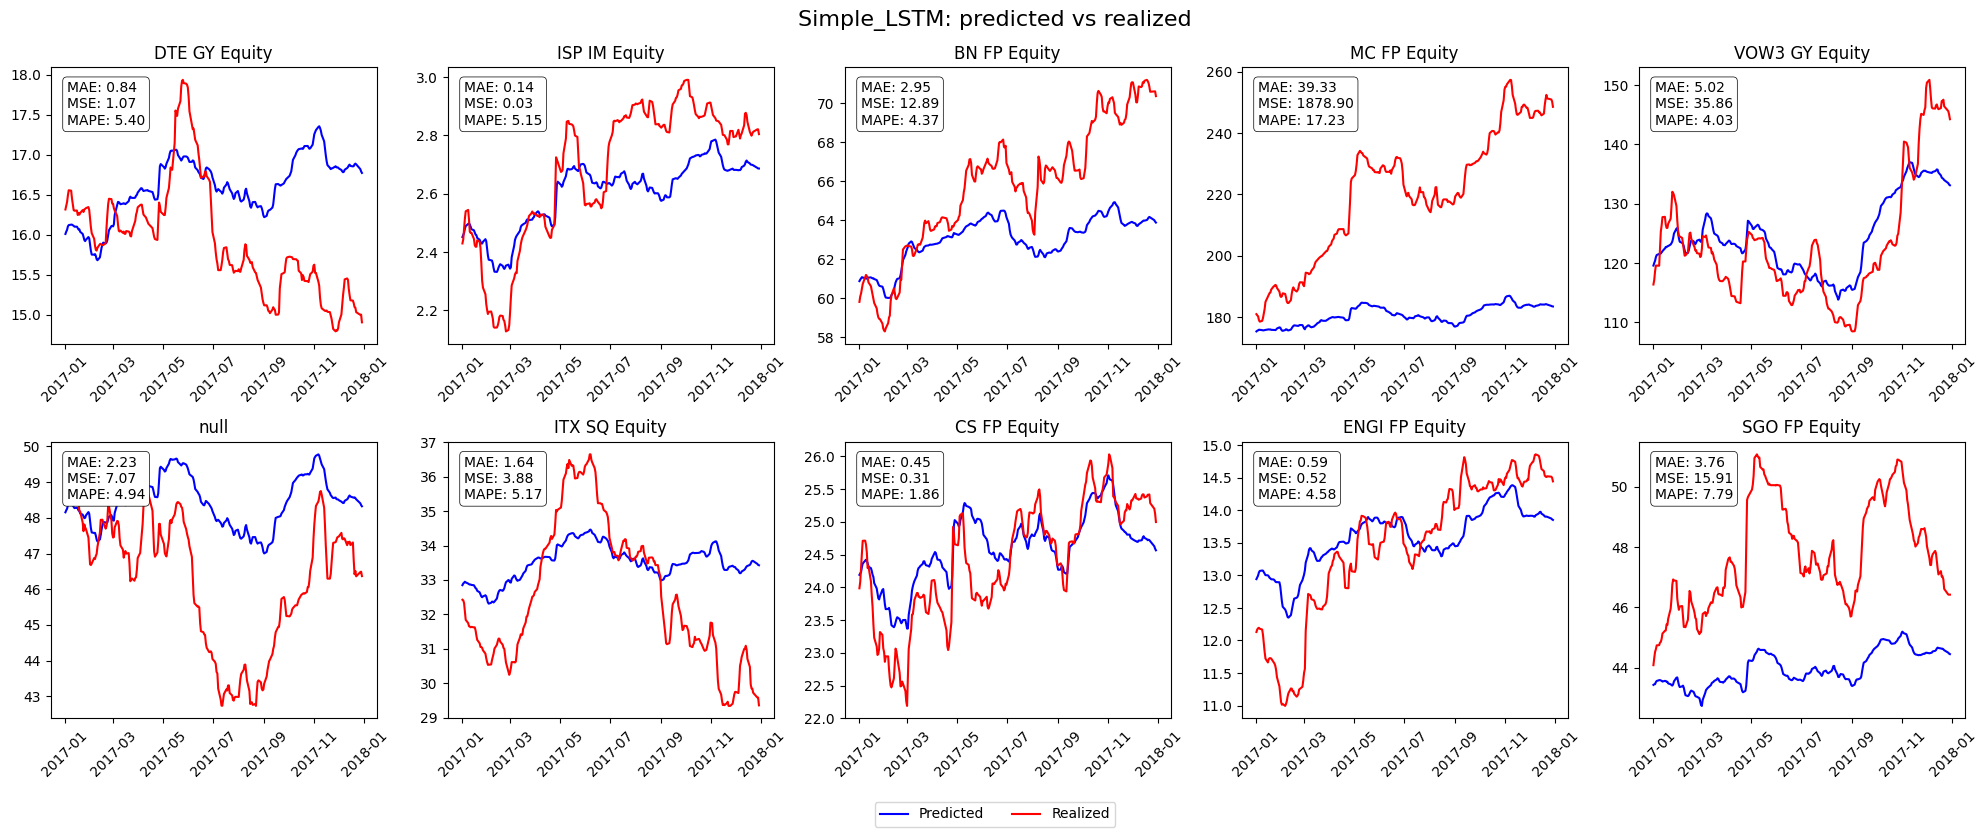

In [ ]:
plot_preds(yhat_inverse, y_test_inverse, metrics_df, model_name=simple_bilstm.name)

#### Portfolio creation, optimization and comparison:
- ranking the predictions
- selecting stocks
- calculate performance of portfolios for different N selections
- plot the portfolios
- compare with index

In [ ]:
# convert to dataframes
yhat_inverse_df = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse_df = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [ ]:
initial_inv = 1000

test_index_series = index.loc['2017-01-02':]
test_index_series = ((test_index_series / test_index_series.iloc[0]) * initial_inv)
test_index_series = pd.Series(test_index_series['Close'], index = test_index_series.index)

portfolios_CNN_biLSTM = get_ranking(yhat_inverse_df, N = [5,7,10], prices=True)
 
tot_performance_CNN_biLSTM, portfolio_series_CNN_biLSTM = calc_portfolios(portfolios_CNN_biLSTM, tukey.loc[yhat_inverse_df.index[0]:], initial_investment=initial_inv)

tot_performance_CNN_biLSTM['Index performance'] = ((test_index_series[-1] - test_index_series[0]) / test_index_series[0]) * 100
tot_performance_CNN_biLSTM

{'Top5 performance': 19.618186241763873,
 'Top7 performance': 13.892514624616137,
 'Top10 performance': 15.20853695297635,
 'Index performance': 7.519056769262942}

In [ ]:
plot_portfolios(portfolio_series_CNN_biLSTM, test_index_series)